In [ ]:
# 单元 1｜导入与路径（最小实现）
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

# 路径常量（按需修改）
RAW_DIR = Path(r"D:\桌面\dataVFI\20250703093040412\EVS\normal_v2_816_612_20250703093040412\evs_raw")
APS_DIR = Path(r"D:\桌面\dataVFI\20250703093040412\APS\quadbayer_10bit_3264_2448_20250703093040412\aps_png")
OUT_DIR = Path(r"D:\桌面\dataVFI\20250703093040412\processed")  # 输出目录

EVS_INFO = Path(r"D:\桌面\dataVFI\20250703093040412\EVS\normal_v2_816_612_20250703093040412_info.txt")
APS_INFO = Path(r"D:\桌面\dataVFI\20250703093040412\APS\quadbayer_10bit_3264_2448_20250703093040412_info.txt")

# 输出目录
gt_DIR.mkdir(parents=True, exist_ok=True)

# 分辨率（EVS）
H, W = 612, 816
print("Paths set. gt_DIR =", gt_DIR.resolve())

Paths set. OUT_DIR = D:\桌面\dataVFI\20250703093040412\processed


In [57]:
# 单元 2｜读取时间戳与对齐文件名（只保留必要字段）
# 自动检测分隔符（逗号或空白）
def read_two_cols(path: Path):
    df = pd.read_csv(path, sep=None, engine="python", dtype=str)
    df.columns = [c.strip().lower() for c in df.columns]
    # 仅取 index, timestamp 两列
    sub = df[["index", "timestamp"]].copy()
    sub["index"] = sub["index"].astype(int)
    sub["timestamp"] = sub["timestamp"].astype(int)
    sub = sub.sort_values("index").reset_index(drop=True)
    return sub

aps_df = read_two_cols(APS_INFO)
evs_df = read_two_cols(EVS_INFO)

# 断言预期长度
# assert len(aps_df) == 200, f"APS info rows should be 200, got {len(aps_df)}"
# assert len(evs_df) == 7800, f"EVS info rows should be 7800, got {len(evs_df)}"

aps_ts = aps_df["timestamp"].to_numpy()   # 长度 200
evs_ts = evs_df["timestamp"].to_numpy()   # 长度 7800

# 文件列表 + 简单一致性检查（按字典序对齐 idx）
aps_files = sorted(APS_DIR.glob("*.png"))
raw_files = sorted(RAW_DIR.glob("*.raw"))

# assert len(aps_files) == 200, f"APS PNG files should be 200, got {len(aps_files)}"
# assert len(raw_files) == 7800, f"EVS RAW files should be 7800, got {len(raw_files)}"

print("Loaded timestamps and listed files:",
      f"APS frames={len(aps_files)}, EVS raws={len(raw_files)}")

Loaded timestamps and listed files: APS frames=200, EVS raws=7800


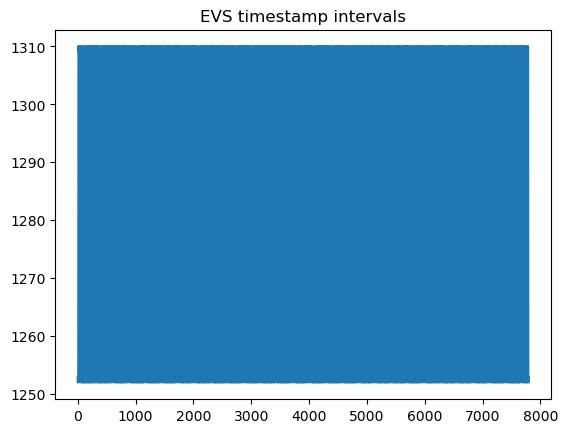

In [34]:
import matplotlib.pyplot as plt
ts_diff = np.diff(evs_ts)  # 相邻时间戳的差值
plt.plot(ts_diff)
plt.title("EVS timestamp intervals")
plt.show()

In [53]:
display(aps_df.head())
display(evs_df.head())

index  timestamp
0      0   53857575
1      1   53907563
2      2   53957551
3      3   54007539
4      4   54057527

index  timestamp
0      0   53843860
1      1   53845113
2      2   53846366
3      3   53847619
4      4   53848872

In [58]:
H, W = 612, 816

def decode_raw_to_events(raw_path: Path, t) -> np.ndarray:
    """将 8-bit/像素的 raw 极性图转为 [x,y,t,p] 事件数组（仅保留非零事件）。
    - 输入 raw: uint8，每像素 1 字节，大小应为 816*612
    - t: 该条 EVS 记录的时间戳（原样 int64）
    - 返回: (N,4) int64 数组，列为 [x,y,t,p]，p ∈ {-1, +1}
    """
    buf = np.frombuffer(raw_path.read_bytes(), dtype=np.uint8)
    buf = buf.copy()
    assert buf.size == H * W, f"{raw_path.name}: size={buf.size} != {H*W} (H*W)"
    pol = buf.reshape(H, W)  # 映射并 reshape
    pol[pol==1]= -1  # 将 1 映射为 -1
    pol[pol==2]= +1  # 将 2 映射为 +1
    # print ("shape of pol is",pol.shape)
    # return pol
    ys, xs = np.nonzero(pol)  # 仅保留非零事件
    if ys.size == 0:
        return np.empty((0, 4), dtype=np.int64)

    pvals = pol[ys, xs].astype(np.int8)
    ts = np.full(xs.shape, np.int64(t), dtype=np.int64)

    # 统一输出为 int64，列顺序 [x, y, t, p]
    events = np.stack([xs.astype(np.int64),
                       ys.astype(np.int64),
                       ts,
                       pvals.astype(np.int64)], axis=1)
    # print ("shape of event is",events.shape)
    return events

In [38]:
# 单元 3｜解码函数（按 8-bit/像素 极性图读取）
# 假设：raw 文件大小恒为 816*612 字节，可直接 reshape 为 (816, 612)
# 极性映射：0->0, 1->-1, 2->+1, 其他(含3)->0

H, W = 612, 816

# 256 长度 LUT：默认 0，其它仅设置 1 和 2
_LUT_U8_TO_POL = np.zeros(256, dtype=np.int8)
_LUT_U8_TO_POL[1] = -1
_LUT_U8_TO_POL[2] = +1

def decode_raw_to_events(raw_path: Path, t) -> np.ndarray:
    """将 8-bit/像素的 raw 极性图转为 [x,y,t,p] 事件数组（仅保留非零事件）。
    - 输入 raw: uint8，每像素 1 字节，大小应为 816*612
    - t: 该条 EVS 记录的时间戳（原样 int64）
    - 返回: (N,4) int64 数组，列为 [x,y,t,p]，p ∈ {-1, +1}
    """
    buf = np.frombuffer(raw_path.read_bytes(), dtype=np.uint8)
    assert buf.size == H * W, f"{raw_path.name}: size={buf.size} != {H*W} (H*W)"
    pol = _LUT_U8_TO_POL[buf].reshape(H, W)  # 映射并 reshape

    ys, xs = np.nonzero(pol)  # 仅保留非零事件
    if ys.size == 0:
        return np.empty((0, 4), dtype=np.int64)

    pvals = pol[ys, xs].astype(np.int8)
    ts = np.full(xs.shape, np.int64(t), dtype=np.int64)

    # 统一输出为 int64，列顺序 [x, y, t, p]
    events = np.stack([xs.astype(np.int64),
                       ys.astype(np.int64),
                       ts,
                       pvals.astype(np.int64)], axis=1)
    print ("shape of event is",events.shape)
    return events

print("decode_raw_to_events ready (8-bit-per-pixel mode).")


decode_raw_to_events ready (8-bit-per-pixel mode).


In [55]:
# 试跑第一个 raw（对应第一个 EVS 时间戳）
demo_events = decode_raw_to_events(raw_files[0], evs_ts[0])
print("first RAW:", raw_files[0].name)
print("t =", int(evs_ts[0]))
print("events shape:", demo_events.shape)

# 前 10 行预览
import pandas as pd
print(pd.DataFrame(demo_events[:10], columns=["x","y","t","p"]).to_string(index=False))

# 极性分布看看
unique, counts = np.unique(demo_events[:,3], return_counts=True)
print("polarity counts:", dict(zip(unique.tolist(), counts.tolist())))



first RAW: 816_612_8_0000000000.raw
t = 53843860
events shape: (2791, 4)
  x  y        t  p
410  0 53843860 -1
514  0 53843860 -1
317  1 53843860 -1
410  1 53843860 -1
411  1 53843860 -1
550  1 53843860 -1
625  1 53843860  1
 17  2 53843860  1
189  2 53843860 -1
579  2 53843860 -1
polarity counts: {-1: 1975, 1: 816}


C:\Users\31237\AppData\Local\Temp\ipykernel_12188\3538191944.py:13: DeprecationWarning: NumPy will stop allowing conversion of out-of-bound Python integers to integer arrays.  The conversion of -1 to uint8 will fail in the future.
For the old behavior, usually:
    np.array(value).astype(dtype)
will give the desired result (the cast overflows).
  pol[pol==1]= -1  # 将 1 映射为 -1


In [43]:
import cv2
def _event_to_image(event, path):
    h, w = event.shape
    image = np.zeros((h, w, 3)) + 255
    image[event[:] > 0] = [0, 0, 255]
    image[event[:] < 0] = [255, 0, 0]
    cv2.imwrite(path, image)
demo_events = decode_raw_to_events(raw_files[0], evs_ts[0])
_event_to_image(demo_events, r"C:\ProgramData\1.png")

C:\Users\31237\AppData\Local\Temp\ipykernel_12188\3538191944.py:13: DeprecationWarning: NumPy will stop allowing conversion of out-of-bound Python integers to integer arrays.  The conversion of -1 to uint8 will fail in the future.
For the old behavior, usually:
    np.array(value).astype(dtype)
will give the desired result (the cast overflows).
  pol[pol==1]= -1  # 将 1 映射为 -1


In [ ]:
# 单元 4｜主循环（按 [timestamp_i, timestamp_{i+1}) 聚合）
TOTAL_EVENTS = 0
written = []

for i in tqdm(range(601), desc="Aggregating by APS intervals"):
    t0 = aps_ts[i]
    t1 = aps_ts[i+1]
    
    # 选择 EVS 条目（半开区间）
    mask = (evs_ts >= t0) & (evs_ts < t1)
    idxs = np.nonzero(mask)[0]
    
    parts = []
    for j in idxs:
        raw_path = raw_files[j]  # 字典序与 index 对齐的简化假设
        t = evs_ts[j]
        ev = decode_raw_to_events(raw_path, t)
        if ev.size:
            parts.append(ev)
    
    if parts:
        events = np.concatenate(parts, axis=0)
    else:
        events = np.empty((0, 4), dtype=np.int64)
    
    TOTAL_EVENTS += events.shape[0]
    
    # 保存为与第 i 帧 PNG 对应的文件名（去扩展名 + _events.npy）
    stem = aps_files[i].stem
    out_path = OUT_DIR / f"{stem}_events.npz"
    np.savez(out_path, events)
    written.append(gt_path)
    
    print(f"[{i:03d}] EVS slices={len(idxs)}, events={events.shape[0]}, saved -> {gt_path.name}")

print(f"Done. Files written: {len(written)}; total events: {TOTAL_EVENTS}")

Aggregating by APS intervals:   0%|          | 0/601 [00:00<?, ?it/s]

C:\Users\31237\AppData\Local\Temp\ipykernel_12188\3538191944.py:13: DeprecationWarning: NumPy will stop allowing conversion of out-of-bound Python integers to integer arrays.  The conversion of -1 to uint8 will fail in the future.
For the old behavior, usually:
    np.array(value).astype(dtype)
will give the desired result (the cast overflows).
  pol[pol==1]= -1  # 将 1 映射为 -1


[000] EVS slices=39, events=124769, saved -> 3264_2448_10_0000000000_events.npz
[001] EVS slices=39, events=115899, saved -> 3264_2448_10_0000000001_events.npz
[002] EVS slices=39, events=120694, saved -> 3264_2448_10_0000000002_events.npz
[003] EVS slices=39, events=130233, saved -> 3264_2448_10_0000000003_events.npz
[004] EVS slices=39, events=206923, saved -> 3264_2448_10_0000000004_events.npz
[005] EVS slices=39, events=237555, saved -> 3264_2448_10_0000000005_events.npz
[006] EVS slices=39, events=255751, saved -> 3264_2448_10_0000000006_events.npz
[007] EVS slices=39, events=490658, saved -> 3264_2448_10_0000000007_events.npz
[008] EVS slices=39, events=414908, saved -> 3264_2448_10_0000000008_events.npz
[009] EVS slices=39, events=197884, saved -> 3264_2448_10_0000000009_events.npz
[010] EVS slices=39, events=145407, saved -> 3264_2448_10_0000000010_events.npz
[011] EVS slices=39, events=148377, saved -> 3264_2448_10_0000000011_events.npz
[012] EVS slices=39, events=205008, save

IndexError: index 200 is out of bounds for axis 0 with size 200

In [ ]:
# 单元 5｜轻量收尾检查
import random

print("Expect 199 files; got:", len(list(gt_DIR.glob("*_events.npz"))))

# 随机抽查 2 个文件（若不足则抽已有的）
written_files = sorted(gt_DIR.glob("*_events.npy"))
sample_n = min(2, len(written_files))
samples = random.sample(written_files, sample_n) if sample_n > 0 else []

for fp in samples:
    arr = np.load(fp, allow_pickle=False)
    print(fp.name, "shape:", arr.shape, "dtype:", arr.dtype)
    if arr.size > 0:
        unique_p = np.unique(arr[:, 3])
        print("p values:", unique_p.tolist())
    else:
        print("empty array.")
print("Check complete.")

Expect 199 files; got: 199
Check complete.


In [62]:
#处理txt
import csv

def extract_timestamps(input_file, output_file):
    """
    从输入的CSV格式txt文件中提取timestamps列，不保留表头，输出到新文件
    
    参数:
        input_file: 输入txt文件路径
        output_file: 输出结果文件路径
    """
    try:
        # 读取输入文件并提取timestamps列
        timestamps = []
        with open(input_file, 'r', newline='', encoding='utf-8') as f:
            # 使用csv阅读器处理逗号分隔的内容
            reader = csv.DictReader(f)
            # 遍历每一行，提取'timestamp'字段的值
            for row in reader:
                timestamps.append(row['timestamp'])
        
        # 将提取的timestamps写入输出文件
        with open(output_file, 'w', encoding='utf-8') as f:
            for ts in timestamps:
                f.write(f"{ts}\n")
        
        print(f"处理完成！共提取 {len(timestamps)} 条timestamps数据，已保存至 {output_file}")
    
    except FileNotFoundError:
        print(f"错误：找不到输入文件 {input_file}")
    except KeyError:
        print("错误：输入文件中未找到 'timestamp' 列，请检查文件格式")
    except Exception as e:
        print(f"处理过程中发生错误：{str(e)}")

if __name__ == "__main__":
    # 输入文件路径（请替换为你的txt文件实际路径）
    input_txt = r"D:\桌面\dataVFI\20250703093040412\APS\quadbayer_10bit_3264_2448_20250703093040412_info.txt"
    # 输出文件路径（结果将保存到该文件）
    output_txt = r"D:\桌面\dataVFI\20250703093040412\info.txt"
    
    # 调用函数执行提取
    extract_timestamps(input_txt, output_txt)

处理完成！共提取 200 条timestamps数据，已保存至 D:\桌面\dataVFI\20250703093040412\info.txt


In [21]:
import numpy as np
# np.set_printoptions(threshold=np.inf)
data = np.load(r"D:\桌面\HRINR\data\正手发球轻动特左\events_aligned\3264_2448_10_0000000000_events.npz")
print(data.files)  # 应该输出 ['events']
print(data.keys())
events = data['arr_0']
print(events.shape)  # (N, 4)
print(events.dtype)  # 一般为 int64
print(events[:5])    # 前5个事件预览
print(events[:, 0])
# print(events[:, 1].astype(np.float32).reshape((-1,)))
(x, y, timestamp, polarity) = (
    events[:, 0].astype(np.float32).reshape((-1,)),
    events[:, 1].astype(np.float32).reshape((-1,)),
    events[:, 2].astype(np.float32).reshape((-1,)),
    events[:, 3].astype(np.float32).reshape((-1,)),
    # tmp["x"].astype(np.float32).reshape((-1,)),
    # tmp["y"].astype(np.float32).reshape((-1,)),
    # tmp["t"].astype(np.float32).reshape((-1,)),
    # tmp["p"].astype(np.float32).reshape((-1,)),
)
events = np.stack((timestamp, x, y, polarity), axis=-1)
print(events.shape)  # (N, 4)
print(events[:, 1])

['arr_0']
KeysView(NpzFile 'D:\\桌面\\HRINR\\data\\正手发球轻动特左\\events_aligned\\3264_2448_10_0000000000_events.npz' with keys: arr_0)
(443685, 4)
int64
[[       18         0 517975804         1]
 [       68         0 517975804         1]
 [       72         0 517975804         1]
 [       74         0 517975804         1]
 [       86         0 517975804        -1]]
[ 18  68  72  74  86  96 131 154 178 197 274 336 434 448 504 514 566 602
   8 185 283 388 393 416   2   3 304 369 426 482 484 495 504 571 584 596
 597 598   1   9  10  56  70 130 142 146 173 176 180 194 210 242 246 250
 254 268 274 278 292 304 330 358 390 400 402 410 456 464 476 500 508  77
  86  93 111 159 175 181 211 376 117 147 217 287 328 344 349  64 196 302
 303 305 324 427 430 499 528 562 572 589 594 609 611  83 401 551 565  22
  24  48  85 125 142 186 190 192 197 206 217 297 342 343 536 576 600 125
 277 281 289 293 295 303 355 361 363 365 367 389 391 393 394 396 419 421
 423 425 433 437 445 447 453 457 465 471 473 475 485 

In [50]:
#下采样
import os
from PIL import Image

def batch_resize_images(input_dir, output_dir, target_width=None, target_height=None, scale_ratio=None):
    """
    批量下采样图像
    :param input_dir: 输入图像文件夹路径
    :param output_dir: 输出图像文件夹路径
    :param target_width: 目标宽度（与target_height同时使用）
    :param target_height: 目标高度（与target_width同时使用）
    :param scale_ratio: 缩放比例（0-1之间，如0.5表示缩小到50%）
    """
    # 创建输出文件夹（如果不存在）
    os.makedirs(output_dir, exist_ok=True)
    
    # 支持的图像格式
    valid_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.gif')
    
    # 遍历输入文件夹中的所有文件
    for filename in os.listdir(input_dir):
        # 检查文件是否为图像
        if filename.lower().endswith(valid_extensions):
            input_path = os.path.join(input_dir, filename)
            output_path = os.path.join(output_dir, filename)
            
            try:
                with Image.open(input_path) as img:
                    # 获取原图尺寸
                    original_width, original_height = img.size
                    
                    # 计算目标尺寸
                    if scale_ratio is not None:
                        # 按比例缩放
                        new_width = int(original_width * scale_ratio)
                        new_height = int(original_height * scale_ratio)
                    elif target_width is not None and target_height is not None:
                        # 按固定尺寸缩放
                        new_width, new_height = target_width, target_height
                    else:
                        raise ValueError("必须指定scale_ratio或target_width和target_height")
                    
                    # 确保尺寸不为0
                    new_width = max(1, new_width)
                    new_height = max(1, new_height)
                    
                    # 下采样（使用LANCZOS算法保持画质）
                    resized_img = img.resize((new_width, new_height), Image.Resampling.LANCZOS)
                    
                    # 保存图像
                    resized_img.save(output_path)
                    print(f"处理完成: {filename} ({original_width}x{original_height} → {new_width}x{new_height})")
            
            except Exception as e:
                print(f"处理失败 {filename}: {str(e)}")

# 使用示例
if __name__ == "__main__":
    # 输入和输出文件夹路径
    input_directory = r"D:\桌面\dataVFI\20250703093040412\APS\quadbayer_10bit_3264_2448_20250703093040412\aps_png" # 替换为你的输入文件夹
    output_directory = r"D:\桌面\dataVFI\20250703093040412\aps_png"# 替换为你的输出文件夹
    
    # # 方法1：按比例缩放（缩小到50%）
    # batch_resize_images(
    #     input_dir=input_directory,
    #     output_dir=output_directory,
    #     scale_ratio=0.5
    # )
    
    # 方法2：按固定尺寸缩放（如统一缩放到640x480）
    batch_resize_images(
        input_dir=input_directory,
        output_dir=output_directory,
        target_width=816,
        target_height=612
    )


处理完成: 3264_2448_10_0000000000.png (3264x2448 → 816x612)
处理完成: 3264_2448_10_0000000001.png (3264x2448 → 816x612)
处理完成: 3264_2448_10_0000000002.png (3264x2448 → 816x612)
处理完成: 3264_2448_10_0000000003.png (3264x2448 → 816x612)
处理完成: 3264_2448_10_0000000004.png (3264x2448 → 816x612)
处理完成: 3264_2448_10_0000000005.png (3264x2448 → 816x612)
处理完成: 3264_2448_10_0000000006.png (3264x2448 → 816x612)
处理完成: 3264_2448_10_0000000007.png (3264x2448 → 816x612)
处理完成: 3264_2448_10_0000000008.png (3264x2448 → 816x612)
处理完成: 3264_2448_10_0000000009.png (3264x2448 → 816x612)
处理完成: 3264_2448_10_0000000010.png (3264x2448 → 816x612)
处理完成: 3264_2448_10_0000000011.png (3264x2448 → 816x612)
处理完成: 3264_2448_10_0000000012.png (3264x2448 → 816x612)
处理完成: 3264_2448_10_0000000013.png (3264x2448 → 816x612)
处理完成: 3264_2448_10_0000000014.png (3264x2448 → 816x612)
处理完成: 3264_2448_10_0000000015.png (3264x2448 → 816x612)
处理完成: 3264_2448_10_0000000016.png (3264x2448 → 816x612)
处理完成: 3264_2448_10_0000000017.png (3264x2448 → 8

In [ ]:
import os
import cv2
import sys
import numpy as np

def find_images_by_name(root_dir, suffix):
    """递归查找所有以指定后缀结尾的图片，返回完整路径列表"""
    result = []
    for cur_dir, _, files in os.walk(root_dir):
        for file in files:
            if file.endswith(suffix):
                result.append(os.path.join(cur_dir, file))
    return sorted(result)

if __name__ == "__main__":
    source_directory = r"D:\Validationnew\faqiu"
    # source_directory = r"D:\Validationnew\aps_png0812"
    image_paths = find_images_by_name(source_directory, suffix='dif.png')
    print(f"共找到 {len(image_paths)} 张图片")
    if not image_paths:
        print("没有找到图片，无法生成视频")
        sys.exit()

    frame = cv2.imread(image_paths[0])
    if frame is None:
        print(f"无法读取图片: {image_paths[0]}")
        sys.exit()
    height, width = frame.shape[:2]
    extra_height = 50  # 底部空白高度

    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    video = cv2.VideoWriter(r"D:\桌面\dif.mp4", fourcc, 80, (width, height + extra_height))

    for img_path in image_paths:
        img = cv2.imread(img_path)
        if img is None:
            print(f"跳过无效图片: {img_path}")
            continue
        # 创建新画布
        canvas = 255 * np.ones((height + extra_height, width, 3), dtype=np.uint8)
        canvas[:height, :, :] = img
        # 在底部空白处写字幕
        basename = os.path.basename(img_path)
        name_no_ext, _ = os.path.splitext(basename) 
        name_no_ext = name_no_ext[17:]
        text = name_no_ext+"-input (HR-INR)"
        position = (20, height + 35)  # 距底部35像素
        font_scale = 5.0
        cv2.putText(canvas, text, position, cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,0), 2, cv2.LINE_AA)
        video.write(canvas)

    video.release()
    print("视频生成完毕，已在每一帧底部添加文件名")

共找到 912 张图片
视频生成完毕，已在每一帧底部添加文件名
